# Zadanie 6

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 7 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1 pkt]
- Wnioski [1 pkt]

Polecane źródła - teoria + intuicja:
- https://distill.pub/2019/paths-perspective-on-value-learning/
- https://www.youtube.com/watch?v=0iqz4tcKN58&ab_channel=SteveBrunton

In [71]:
import numpy as np
import gymnasium
from gymnasium.core import Env
import matplotlib.pyplot as plt

In [72]:
class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(self, observation_space: int, action_space: int, learning_rate: float = 0.1,
                 gamma: float = 0.9, epsilon: float = 0.1):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((observation_space, action_space))

    def __call__(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:
        """Return Q-value of given state and action."""
        return self.Q[state, action]

    def update(self, state: np.ndarray, action: np.ndarray, next_state: np.ndarray, reward: float) -> None:
        """Update Q-value of given state and action."""
        self.Q[state, action] = (self.Q[state, action] + self.learning_rate *
                                 (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state, action]))

    def get_best_action(self, state: np.ndarray) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(0, self.action_space)
        else:
            return np.argmax(self.Q[state])

    def reset(self):
        self.Q = np.zeros((self.observation_space, self.action_space))

    def __repr__(self) -> str:
        """Elegant representation of Q-learning solver."""
        message = f"Observation space: {self.observation_space},\nAction space: {self.action_space},\n"
        message += f"Learning rate: {self.learning_rate},\nGamma: {self.gamma},\nEpsilon: {self.epsilon},\n"
        if self.Q.shape[0] < 100 and self.Q.shape[1] < 30:
            message += f"Q matrix shape: {self.Q.shape}\n"
            message += str(self.Q)
        else:
            message += f"Q matrix shape: {self.Q.shape}, to big to display"
        return message

    def __str__(self):
        return self.__repr__()

In [73]:
class TaxiQLearningSolver:
    def __init__(self, environment: Env, learning_rate: float = 0.1, gamma: float = 0.9, epsilon: float = 0.1, verbose=0):
        self.environment = environment
        self.verbose = verbose
        self.solver = QLearningSolver(observation_space=self.environment.observation_space.n, action_space=self.environment.action_space.n,
                                      learning_rate=learning_rate, gamma=gamma, epsilon=epsilon)

    def set_solver_parameters(self, learning_rate: float, gamma: float, epsilon: float):
        self.solver.learning_rate = learning_rate
        self.solver.gamma = gamma
        self.solver.epsilon = epsilon
        self.solver.reset()

    def set_verbose(self, verbose: int):
        self.verbose = verbose

    def train(self, epochs: int, steps_per_epoch: int):
        self.solver.reset()
        return self._solve(epochs, steps_per_epoch, True)

    def test(self, tests_number: int, steps_per_test: int):
        return self._solve(tests_number, steps_per_test, False)

    def _solve(self, iterations_number: int, steps_per_iteration: int, is_training: bool):
        rewards = []
        results = []
        steps = []
        successful_iterations = 0
        is_done = False

        for iteration in range(1, iterations_number + 1):
            state = self.environment.reset()[0]
            iteration_reward = 0
            for step in range(1, steps_per_iteration + 1):
                chosen_action = self.solver.get_best_action(state)
                next_state, reward, is_done, _, _ = self.environment.step(int(chosen_action))
                iteration_reward += reward
                if is_training:
                    self.solver.update(state, chosen_action, next_state, reward)
                state = next_state

                if is_done:
                    break

            if is_done:
                successful_iterations += 1
                success_status = "Success"
            else:
                success_status = "Failure"
            if self.verbose == 2:
                if is_training:
                    print(f"Epoch: {iteration:<8} Steps: {step:<8} Epoch reward: {iteration_reward:<13} {success_status:<8}")
                else:
                    print(f"Test number: {iteration:<8} Steps: {step:<8} Test reward: {iteration_reward:<13} {success_status:<8}")
            rewards.append(iteration_reward)
            results.append(is_done)
            steps.append(step)

        if self.verbose:
            print()
            if is_training:
                print(f"Successful epochs: {successful_iterations} ({(successful_iterations / iterations_number)*100:.2f}%)")
            else:
                print(f"Successful tests: {successful_iterations} ({(successful_iterations / iterations_number)*100:.2f}%)")
            print(f"Max reward: {max(rewards)}; Min reward: {min(rewards)}; Average reward: {sum(rewards)/len(rewards)}")
            print(f"Max steps number: {max(steps)}; Min steps number: {min(steps)}; Average steps number: {sum(steps)/len(steps)}")

        return rewards, results, steps


# Eksperymenty

### Eksperyment 1
Na początku uruchomiono funkcję do trenowania modelu z ustawionymi parametrami `learning_rate=0.1`, `gamma=0.9`, `epsilon=0.1`. Ustawiono ilość epok przy trenowaniu na 1000 oraz maksymalną ilość kroków, jaką można wykonać podczas epoki na 100.


Successful epochs: 435 (43.50%)
Max reward: 15; Min reward: -352; Average reward: -106.258
Max steps number: 100; Min steps number: 6; Average steps number: 78.268


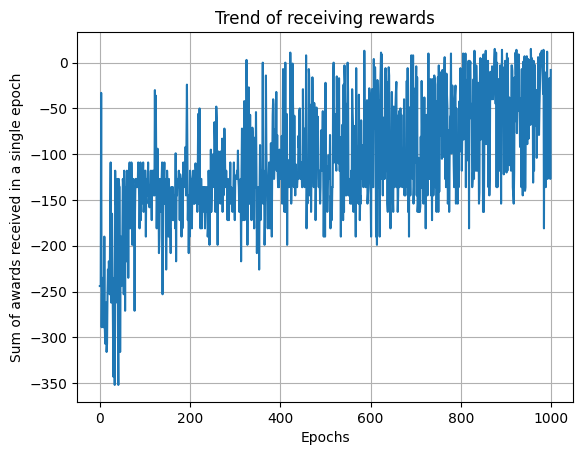

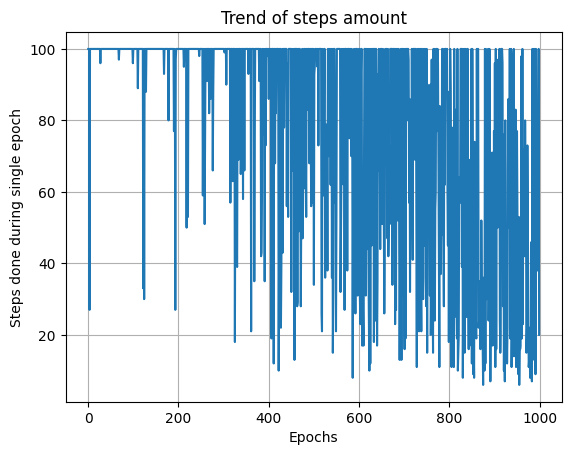

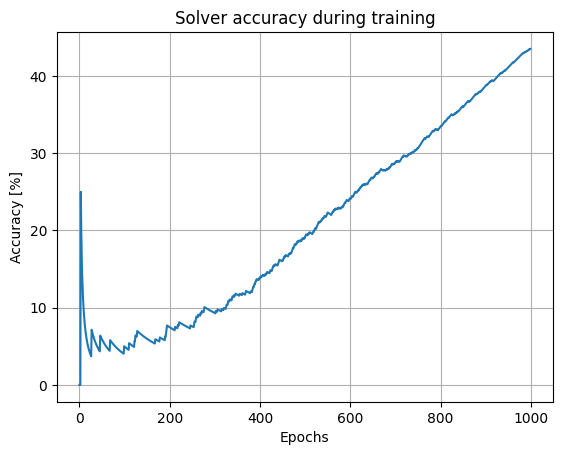

In [74]:
environment = gymnasium.make('Taxi-v3')
testing_solver = TaxiQLearningSolver(environment, learning_rate=0.1, gamma=0.9, epsilon=0.1, verbose=1)
rewards, results, steps = testing_solver.train(epochs=1000, steps_per_epoch=100)

plt.plot(rewards)
plt.xlabel("Epochs")
plt.ylabel("Sum of awards received in a single epoch")
plt.title("Trend of receiving rewards")
plt.grid()
plt.show()

plt.plot(steps)
plt.xlabel("Epochs")
plt.ylabel("Steps done during single epoch")
plt.title("Trend of steps amount")
plt.grid()
plt.show()

accuracies = [len([results[x] for x in range(epoch_number) if results[x]])/epoch_number*100 for epoch_number in range(1, len(results) + 1)]
plt.plot([x for x in range(len(results))], accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy [%]")
plt.title("Solver accuracy during training")
plt.grid()
plt.show()

Na powyższych danych widać, że skuteczność solvera liczona jako stosunek ilości poprawnie ukończonych epok do ich całkowitej liczby, wyniósł około 43%. Trzeba podkreślić, że algorytm nie jest deterministyczny i za każdym uruchomieniem programu liczba ta się nieznacznie zmienia. Na wykresach można zauważyć, jak na początku solver otrzymywał słabe wartości nagród, z czasem polepszając swoje wyniki, jednakże cały czas zachowując spory rozrzut wartości między sąsiednimi epokami. Na drugim wykresie została przedstawiona tendencja skuteczności w zależności od liczby epok, która to w tym przypadku wydaje się być liniowa. Ciekawy jest parametr `Min steps number: 6` pokazujący, że algorytm jest w stanie dotrzeć do celu w minimalnej liczbie akcji.

Poniższy kod służy do przetestowania nauczonego algorytmu:


Successful tests: 18 (18.00%)
Max reward: 14; Min reward: -47; Average reward: -20.02
Max steps number: 20; Min steps number: 7; Average steps number: 18.31


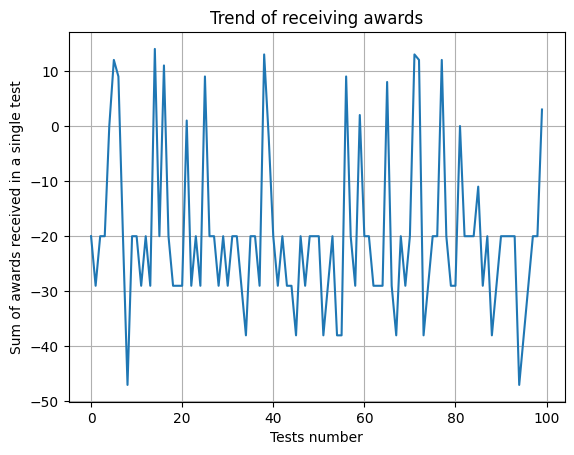

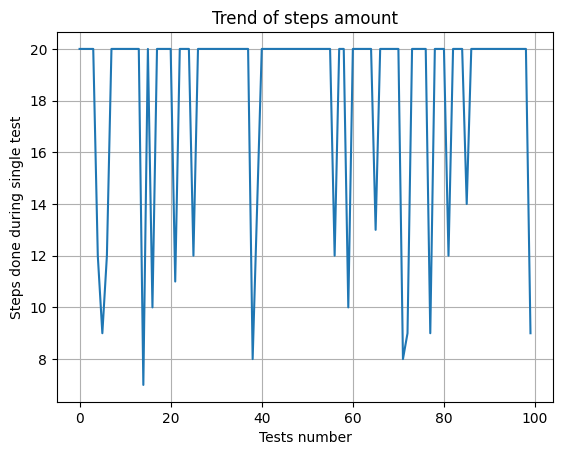

In [75]:
rewards, results, steps = testing_solver.test(tests_number=100, steps_per_test=20)

plt.plot(rewards)
plt.xlabel("Tests number")
plt.ylabel("Sum of awards received in a single test")
plt.title("Trend of receiving awards")
plt.grid()
plt.show()

plt.plot(steps)
plt.xlabel("Tests number")
plt.ylabel("Steps done during single test")
plt.title("Trend of steps amount")
plt.grid()
plt.show()

W tym przypadku liczba wykonanych kroków oraz wartość otrzymanych nagród nie posiada żadnej zależności względem numeru wykonywanego testu, co jest zrozumiałe, ponieważ model został już nauczony, a więc powinien działać cały czas z podobną skutecznością, oczywiście z uwzględnieniem dodanej losowości.

### Eksperyment 2
W tym eksperymencie wydłużono ilość epok do 10000


Successful epochs: 9418 (94.18%)
Max reward: 15; Min reward: -397; Average reward: -10.0188
Max steps number: 100; Min steps number: 6; Average steps number: 22.1835


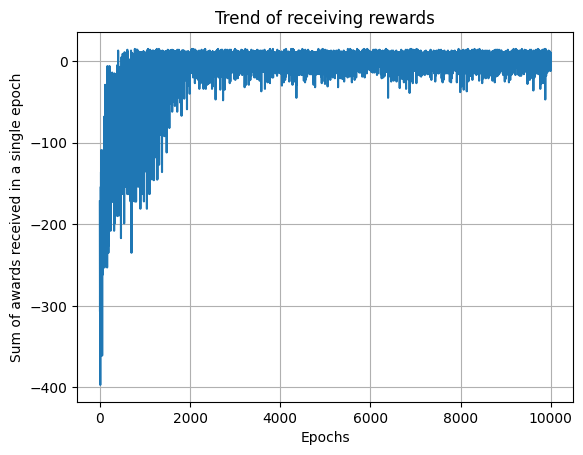

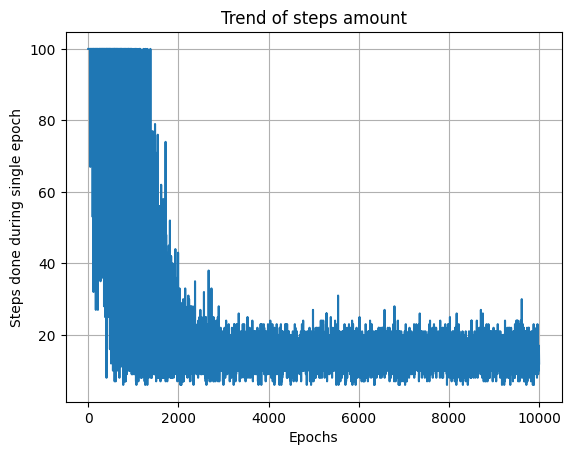

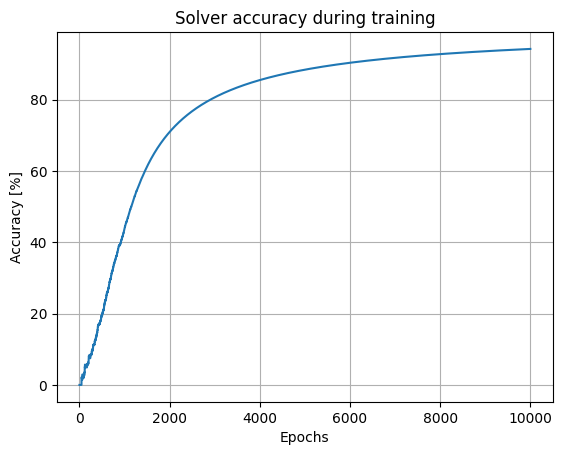

In [76]:
rewards, results, steps = testing_solver.train(epochs=10000, steps_per_epoch=100)

plt.plot(rewards)
plt.xlabel("Epochs")
plt.ylabel("Sum of awards received in a single epoch")
plt.title("Trend of receiving rewards")
plt.grid()
plt.show()

plt.plot(steps)
plt.xlabel("Epochs")
plt.ylabel("Steps done during single epoch")
plt.title("Trend of steps amount")
plt.grid()
plt.show()

accuracies = [len([results[x] for x in range(epoch_number) if results[x]])/epoch_number*100 for epoch_number in range(1, len(results) + 1)]
plt.plot([x for x in range(len(results))], accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy [%]")
plt.title("Solver accuracy during training")
plt.grid()
plt.show()


Successful tests: 92 (92.00%)
Max reward: 14; Min reward: -38; Average reward: 1.27
Max steps number: 20; Min steps number: 7; Average steps number: 14.72


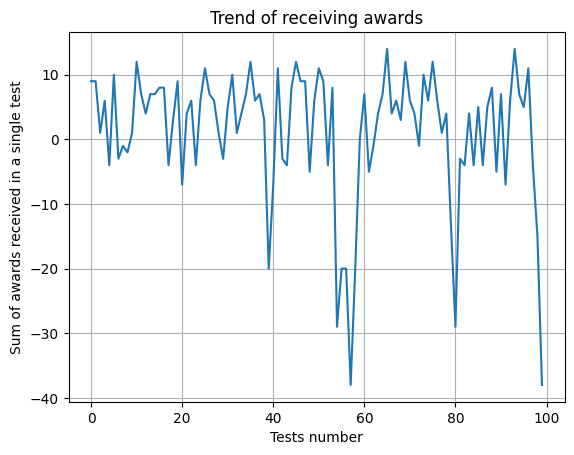

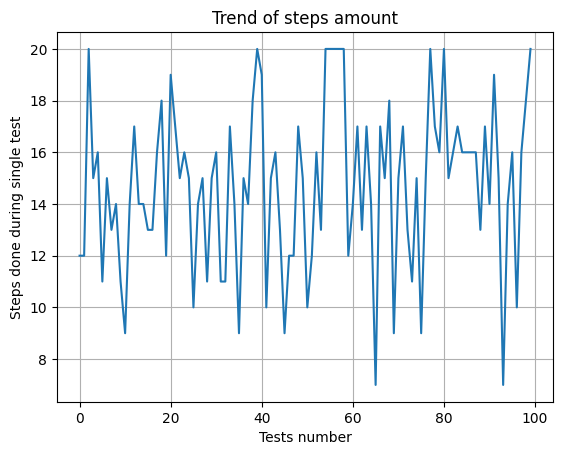

In [77]:
rewards, results, steps = testing_solver.test(tests_number=100, steps_per_test=20)

plt.plot(rewards)
plt.xlabel("Tests number")
plt.ylabel("Sum of awards received in a single test")
plt.title("Trend of receiving awards")
plt.grid()
plt.show()

plt.plot(steps)
plt.xlabel("Tests number")
plt.ylabel("Steps done during single test")
plt.title("Trend of steps amount")
plt.grid()
plt.show()

Tym razem wytrenowano model na większej ilości epok, co jak widać, poskutkowało zwiększeniem skuteczności solvera podczas testów z 20% do około 95%. Zmalała też średnia ilość kroków wykonywanych podczas każdego z testów. Co ciekawe, nadal prawdopodobieństwo znalezienia najkrótszej drogi wynoszącej 6 jest na tyle małe, że nie wystąpiło podczas testów.

### Eksperyment 3
Tym razem dodatkowo zwiększono maksymalną dopuszczalną ilość kroków wykonywanych podczas jednej epoki do 1000:


Successful epochs: 9995 (99.95%)
Max reward: 15; Min reward: -2377; Average reward: -9.6033
Max steps number: 1000; Min steps number: 6; Average steps number: 22.7997


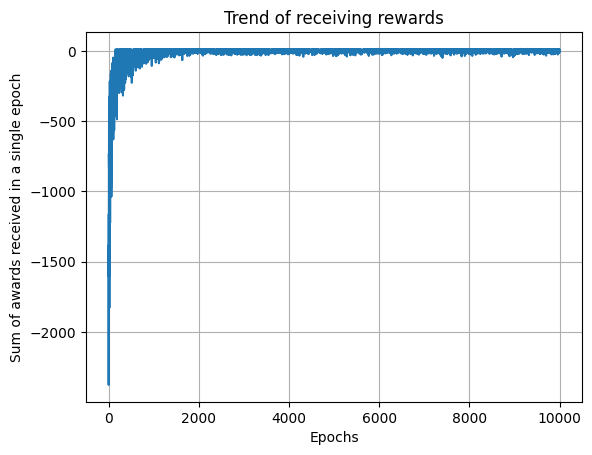

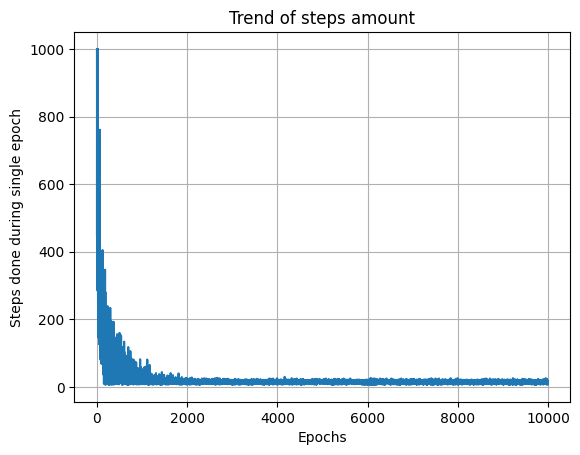

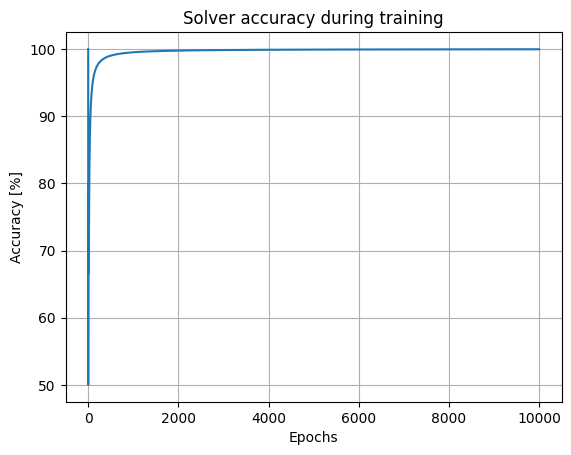

In [78]:
rewards, results, steps = testing_solver.train(epochs=10000, steps_per_epoch=1000)

plt.plot(rewards)
plt.xlabel("Epochs")
plt.ylabel("Sum of awards received in a single epoch")
plt.title("Trend of receiving rewards")
plt.grid()
plt.show()

plt.plot(steps)
plt.xlabel("Epochs")
plt.ylabel("Steps done during single epoch")
plt.title("Trend of steps amount")
plt.grid()
plt.show()

accuracies = [len([results[x] for x in range(epoch_number) if results[x]])/epoch_number*100 for epoch_number in range(1, len(results) + 1)]
plt.plot([x for x in range(len(results))], accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy [%]")
plt.title("Solver accuracy during training")
plt.grid()
plt.show()


Successful tests: 96 (96.00%)
Max reward: 14; Min reward: -29; Average reward: 2.04
Max steps number: 20; Min steps number: 7; Average steps number: 14.79


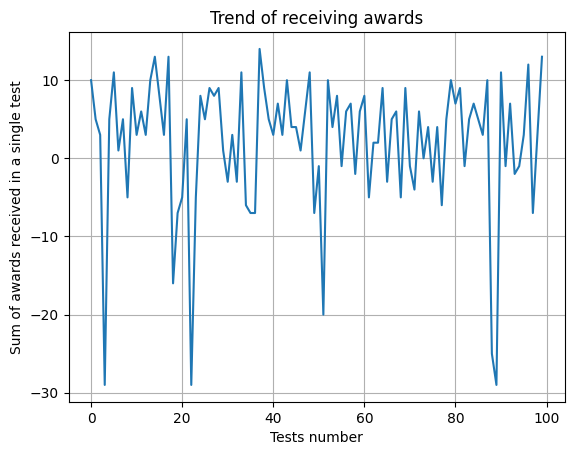

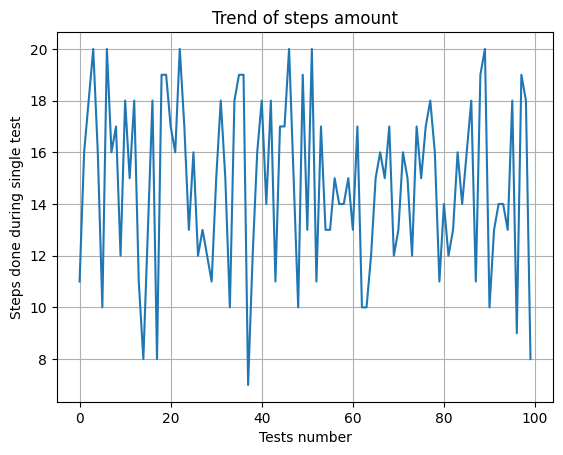

In [79]:
rewards, results, steps = testing_solver.test(tests_number=100, steps_per_test=20)

plt.plot(rewards)
plt.xlabel("Tests number")
plt.ylabel("Sum of awards received in a single test")
plt.title("Trend of receiving awards")
plt.grid()
plt.show()

plt.plot(steps)
plt.xlabel("Tests number")
plt.ylabel("Steps done during single test")
plt.title("Trend of steps amount")
plt.grid()
plt.show()

Wyniki pokazują, że nie przyniosło to prawie żadnych korzyści, ale też nie wydłużyło prawie w ogóle czasu wykonywania się programu, gdyż solver wykorzystuje ten zwiększony limit tylko na początku, potem już proces trenowania odbywa się podobnie jak wcześniej.

### Eksperyment 4

__________________________________________________________________________________________

	Testing learning rate influence. Other parameters: gamma = 0.9, epsilon = 0.1

_____________________________________________

	learning_rate = 0.01, gamma = 0.9, epsilon = 0.1

Successful epochs: 5100 (51.00%)
Max reward: 15; Min reward: -361; Average reward: -89.6837
Max steps number: 100; Min steps number: 6; Average steps number: 73.4315

Successful tests: 27 (27.00%)
Max reward: 15; Min reward: -65; Average reward: -17.29
Max steps number: 20; Min steps number: 6; Average steps number: 17.83
_____________________________________________

	learning_rate = 0.12, gamma = 0.9, epsilon = 0.1

Successful epochs: 9513 (95.13%)
Max reward: 15; Min reward: -379; Average reward: -8.2607
Max steps number: 100; Min steps number: 6; Average steps number: 21.0956

Successful tests: 92 (92.00%)
Max reward: 15; Min reward: -56; Average reward: 0.75
Max steps number: 20; Min steps number: 6; Average steps n

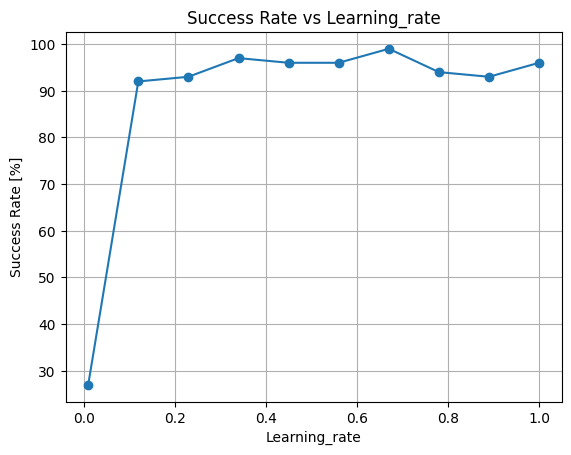


__________________________________________________________________________________________

	Testing gamma influence. Other parameters: learning rate = 0.1, epsilon = 0.1

_____________________________________________

	learning_rate = 0.1, gamma = 0.5, epsilon = 0.1

Successful epochs: 9107 (91.07%)
Max reward: 15; Min reward: -406; Average reward: -17.6532
Max steps number: 100; Min steps number: 6; Average steps number: 28.0389

Successful tests: 88 (88.00%)
Max reward: 15; Min reward: -38; Average reward: 0.45
Max steps number: 20; Min steps number: 6; Average steps number: 14.34
_____________________________________________

	learning_rate = 0.1, gamma = 0.5544444444444444, epsilon = 0.1

Successful epochs: 9190 (91.90%)
Max reward: 15; Min reward: -352; Average reward: -15.9771
Max steps number: 100; Min steps number: 6; Average steps number: 26.7954

Successful tests: 85 (85.00%)
Max reward: 14; Min reward: -38; Average reward: -1.97
Max steps number: 20; Min steps number: 7; A

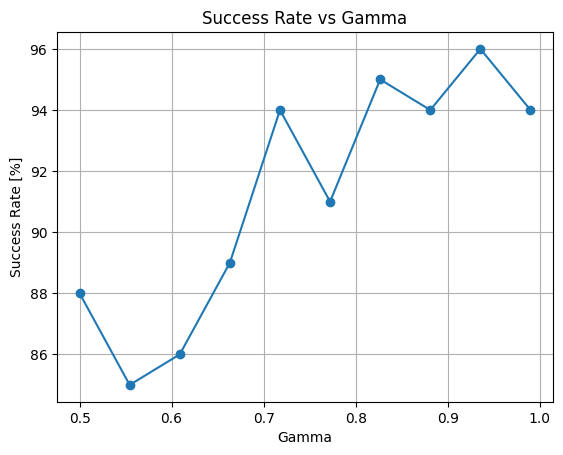


__________________________________________________________________________________________

Testing epsilon influence. Other parameters: learning_rate = 0.1, gamma = 0.9

_____________________________________________

	learning_rate = 0.1, gamma = 0.9, epsilon = 0.01

Successful epochs: 9470 (94.70%)
Max reward: 15; Min reward: -334; Average reward: -4.098
Max steps number: 100; Min steps number: 6; Average steps number: 20.5893

Successful tests: 100 (100.00%)
Max reward: 14; Min reward: -5; Average reward: 7.55
Max steps number: 18; Min steps number: 7; Average steps number: 13.09
_____________________________________________

	learning_rate = 0.1, gamma = 0.9, epsilon = 0.12

Successful epochs: 9421 (94.21%)
Max reward: 15; Min reward: -370; Average reward: -11.5901
Max steps number: 100; Min steps number: 6; Average steps number: 22.5767

Successful tests: 90 (90.00%)
Max reward: 15; Min reward: -47; Average reward: -1.27
Max steps number: 20; Min steps number: 6; Average steps nu

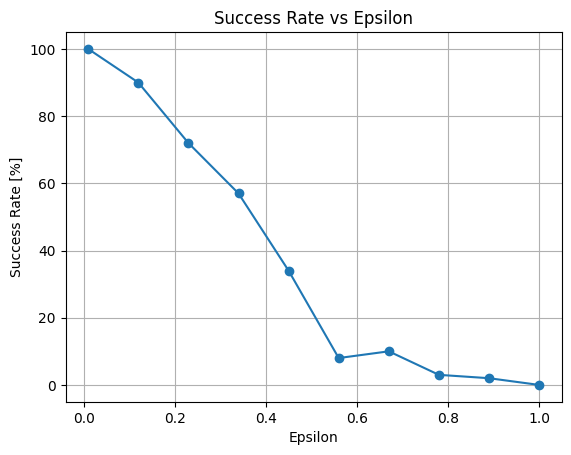

In [84]:
learning_rate_values = np.linspace(0.01, 1.0, 10)
gamma_values = np.linspace(0.5, 0.99, 10)
epsilon_values = np.linspace(0.01, 1.0, 10)

epochs = 10000
steps_per_epoch = 100
test_iterations = 100
steps_per_test = 20
fixed_parameters = {"learning_rate": 0.1, "gamma": 0.9, "epsilon": 0.1}

results_learning_rate = []
results_gamma = []
results_epsilon = []

testing_solver.set_verbose(verbose=1)

print(30*"___")
print(f"\n\tTesting learning rate influence. Other parameters: gamma = {fixed_parameters['gamma']}, epsilon = {fixed_parameters['epsilon']}")
print()

for learning_rate in learning_rate_values:
    print(f"{15*'___'}\n")
    print(f"\tlearning_rate = {learning_rate}, gamma = {fixed_parameters['gamma']}, epsilon = {fixed_parameters['epsilon']}")
    testing_solver.set_solver_parameters(learning_rate=learning_rate, gamma=fixed_parameters["gamma"], epsilon=fixed_parameters["epsilon"])
    testing_solver.train(epochs, steps_per_epoch)
    _, test_results, _ = testing_solver.test(test_iterations, steps_per_test)
    success_rate = sum(test_results) / len(test_results) * 100
    results_learning_rate.append(success_rate)

plt.plot(learning_rate_values, results_learning_rate, marker='o')
plt.title("Success Rate vs Learning_rate")
plt.xlabel("Learning_rate")
plt.ylabel("Success Rate [%]")
plt.grid()
plt.show()

print()
print(30*"___")
print(f"\n\tTesting gamma influence. Other parameters: learning rate = {fixed_parameters['learning_rate']}, epsilon = {fixed_parameters['epsilon']}")
print()

for gamma in gamma_values:
    print(f"{15*'___'}\n")
    print(f"\tlearning_rate = {fixed_parameters['learning_rate']}, gamma = {gamma}, epsilon = {fixed_parameters['epsilon']}")
    testing_solver.set_solver_parameters(learning_rate=fixed_parameters["learning_rate"], gamma=gamma, epsilon=fixed_parameters["epsilon"])
    testing_solver.train(epochs, steps_per_epoch)
    _, test_results, _ = testing_solver.test(test_iterations, steps_per_test)
    success_rate = sum(test_results) / len(test_results) * 100
    results_gamma.append(success_rate)

plt.plot(gamma_values, results_gamma, marker='o')
plt.title("Success Rate vs Gamma")
plt.xlabel("Gamma")
plt.ylabel("Success Rate [%]")
plt.grid()
plt.show()

print()
print(30*"___")
print(f"\nTesting epsilon influence. Other parameters: learning_rate = {fixed_parameters['learning_rate']}, gamma = {fixed_parameters['gamma']}")
print()

for epsilon in epsilon_values:
    print(f"{15*'___'}\n")
    print(f"\tlearning_rate = {fixed_parameters['learning_rate']}, gamma = {fixed_parameters['gamma']}, epsilon = {epsilon}")
    testing_solver.set_solver_parameters(learning_rate=fixed_parameters["learning_rate"], gamma=fixed_parameters["gamma"], epsilon=epsilon)
    testing_solver.train(epochs, steps_per_epoch)
    _, test_results, _ = testing_solver.test(test_iterations, steps_per_test)
    success_rate = sum(test_results) / len(test_results) * 100
    results_epsilon.append(success_rate)

plt.plot(epsilon_values, results_epsilon, marker='o')
plt.title("Success Rate vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Success Rate [%]")
plt.grid()

Parametr `learning_rate` określa szybkość uczenia się, jest to stopień, w jakim algorytm uwzględnia różnicę między predykowanym przyszłym stanem Q, a obecnym stanem Q podczas aktualizowania wartości tej macierzy współczynników. Dla wartości bliskiej zero szybkość uczenia się jest bardzo wolna, dlatego też solver uzyskuje dla niej małą skuteczność. W tym konkretnym przypadku powyżej pewnej wartości tego parametru skuteczność pozostaje względnie stała.

`gamma` określa przyczynek od predykowanego stanu na uaktualnianie wartości w macierzy Q. Im większa wartość tego parametru tym lepiej. Najlepsze działanie slovera uzyskuje się dla domyślnej wartości 0,9.

Stała `epsilon`określa strategię, z jaką wybierany jest ruch - czy jest to ruch losowy, czy jest wybrany najlepszy predykowany. Dla małej jego wartości statystycznie często wybierana jest strategia zachłanna, co umożliwia na dokładne przeszukanie przestrzeni. Dla dużej jego wartości częściej wybierana jest strategia losowa. Pozwala to na przeszukiwanie nowych fragmentów przestrzeni, ale jednak podczas działania algorytmu ogranicza jego skuteczność, gdyż wtedy alfgorytm nie wykorzystuje często zgromadzonej prze siebie wiedzy.

